<a href="https://colab.research.google.com/github/amadoujr/MultimodalRAG-Chatbot-Using-colpali/blob/main/RAG_Conversation_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade  langchain langchain-community gradio   #langchainhub
!pip install pypdf -q
!sudo apt-get install -y poppler-utils --quiet
!pip install --quiet --upgrade byaldi

In [ ]:
#os.environ["GOOGLE_API_KEY"] = os.getenv("HF_GEMINI_SECRET_KEY")

In [ ]:
!pip install langchain-google-genai --quiet

In [ ]:
import os
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import gradio as gr
import csv
from langchain.chains import create_retrieval_chain,create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.retrievers import BaseRetriever
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.language_models.llms import LLM
from byaldi import RAGMultiModalModel
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
import os
import base64

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

### Loading a model with byaldi


In [ ]:
# Optionally, you can specify an `index_root`, which is where it'll save the index. It defaults to ".byaldi/".
rag_model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Indexing our data

In [ ]:
%ls .byaldi/cv_data/embeddings

embeddings_0.pt


In [ ]:
import torch
embeddings = torch.load('.byaldi/cv_data/embeddings/embeddings_0.pt')


<ipython-input-31-3f11a4ebd5d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('.byaldi/cv_data/embeddings/embeddings_0.pt')


In [ ]:
embeddings_tensor = torch.stack(embeddings)

In [ ]:
embeddings_tensor = embeddings_tensor.squeeze()
embeddings_tensor.shape

torch.Size([747, 128])

In [ ]:
embeddings_tensor

tensor([[ 0.0206, -0.0864, -0.0713,  ...,  0.0518, -0.0030,  0.1108],
        [ 0.0193, -0.1084, -0.0264,  ...,  0.0757, -0.0452, -0.1396],
        [-0.0017, -0.0986, -0.0197,  ...,  0.0762, -0.0342, -0.1299],
        ...,
        [ 0.0491, -0.0967, -0.0933,  ...,  0.0476,  0.0339,  0.0737],
        [ 0.0270, -0.1367, -0.0439,  ...,  0.0303, -0.0371, -0.1318],
        [ 0.0554, -0.1406, -0.1074,  ..., -0.0664,  0.0405,  0.0291]])

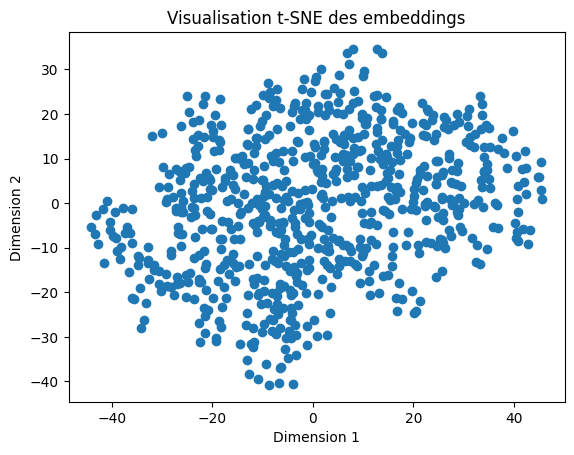

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Réduire la dimensionnalité des embeddings avec t-SNE
tsne = TSNE(n_components=3)
embeddings_tensor = embeddings_tensor.type(torch.float32)
embeddings_2d = tsne.fit_transform(embeddings_tensor.cpu().detach().numpy())

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("Visualisation t-SNE des embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
%ls -al .byaldi/cv_data/embeddings

total 196
drwxr-xr-x 2 root root   4096 Mar 10 14:42 ./
drwxr-xr-x 4 root root   4096 Mar 10 14:42 ../
-rw-r--r-- 1 root root 192437 Mar 10 14:42 embeddings_0.pt


In [ ]:
def index_model(index_name,path_file):
    index_name = index_name
    rag_model.index(
    input_path=path_file, # The path to your documents
    index_name=index_name, # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
    store_collection_with_index=True, # Whether the index should store the base64 encoded documents.
    overwrite=True # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
    )

In [ ]:
index_model("cv_data", "/content/Amadou_Barro_CV.pdf")

Added page 1 of document 0 to index.
Index exported to .byaldi/cv_data
Index exported to .byaldi/cv_data


In [ ]:
text_query = "A qui appartient ce CV?"
rag_model.search(text_query, k=1)

[{'doc_id': 0, 'page_num': 1, 'score': 12.375, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABncAAAkkCAIAAABBbL0UAAEAAElEQVR4nOzdV3Qc17kn+qrOjUjkHAgQmQARSIAkmMCclKNlyZYtjcfpzNx1z5k7L3etebprzcuk43OcJFmybCtZmaLEDIKZYABJkAQBEETOOXXurvvQEgx1V3Xvyg3g/xsdj1Soqr1r1+5dXV/vQDMMQwEAAAAAAAAAAIAIGrUzAAAAAAAAAAAAsOQhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAglm5mZubtv/xN7WwAAAAAAAAAAAAsVT/50cs6D8NYrDa1cwIAAAAAAAAAALBUMR5GR1GU3elQOycAAAAAAAAAAABLFUMxOoZh3Ayjdk4AAAAAAAAAAACWMKx+AAAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAA

#### Integrate ColPali (Byaldi) with LangChain to create the retriever

In [ ]:
class ByaldiRetriever(BaseRetriever):

    def _get_relevant_documents(self, query: str):
        k: int = 1
        # Use Byaldi to search for relevant documents
        results = rag_model.search(query, k=k)

        # Convert results into LangChain's Document format
        documents = []
        for result in results:
            doc = Document(
                page_content=result["base64"],
                metadata={
                    "doc_id": result["doc_id"],
                    "page_num": result["page_num"],
                    "score": result["score"],
                }
            )
            documents.append(doc)
        return documents

retriever = ByaldiRetriever()

In [ ]:
docs = retriever.invoke(text_query)

In [ ]:
docs

[Document(metadata={'doc_id': 0, 'page_num': 1, 'score': 12.375}, page_content='iVBORw0KGgoAAAANSUhEUgAABncAAAkkCAIAAABBbL0UAAEAAElEQVR4nOzdV3Qc17kn+qrOjUjkHAgQmQARSIAkmMCclKNlyZYtjcfpzNx1z5k7L3etebprzcuk43OcJFmybCtZmaLEDIKZYABJkAQBEETOOXXurvvQEgx1V3Xvyg3g/xsdj1Soqr1r1+5dXV/vQDMMQwEAAAAAAAAAAIAIGrUzAAAAAAAAAAAAsOQhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAglm5mZubtv/xN7WwAAAAAAAAAAAAsVT/50cs6D8NYrDa1cwIAAAAAAAAAALBUMR5GR1GU3elQOycAAAAAAAAAAABLFUMxOoZh3Ayjdk4AAAAAAAAAAACWMKx+AAAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBaibAAAAAAAAAAAAGIhygYAAAAAAAAAACAWomwAAAAAAAAAAABiIcoGAAAAAAAAAAAgFqJsAAAAAAAAAAAAYiHKBgAAAAAAAAAAIBai

### Loading the VLM model

In [ ]:
# Load Qwen2-VL model and processor
model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

### Custome llm to use Vlm into Langchain

In [ ]:
from typing import Any, Optional
from langchain.callbacks.manager import CallbackManagerForLLMRun

class Qwen2VLLM(LLM):
    """Qwen2-VL large language model."""

    model: Any  # type: ignore
    processor: Any # type: ignore

    @property
    def _llm_type(self) -> str:
        """Return type of llm."""
        return "qwen2-vl"


    def _call(
        self,
        prompt: str,
        stop: Optional[list[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> str:
        image_base64 = kwargs.get("image_base64")
        if not image_base64:
            raise ValueError("image_base64 is required in kwargs")

        image_data = base64.b64decode(image_base64)
        image = Image.open(io.BytesIO(image_data))
        inputs = self.processor(
            text=prompt,
            images=image,
            return_tensors="pt",
            padding=True,
        ).to("cuda")
        generated_ids = self.model.generate(**inputs, max_new_tokens=200)
        response = self.processor.decode(generated_ids[0], skip_special_tokens=True)

        return response


# Initialize custom LLM, passing the model and processor when invoking
qwen2_vl_llm = Qwen2VLLM(model=model, processor=processor) # This line should be used when invoking, not for initializing



```
# # Assuming you have a base64 encoded image named 'your_image_base64'
your_image_base64 = "your_base64_encoded_image_here" # Replace with your actual base64 image string

# Now you pass image_base64 as a keyword argument when invoking:
custom_llm = qwen2_vl_llm
response = custom_llm.invoke("Votre prompt ici", image_base64=your_image_base64)
# Création du retriever conscient de l'historique
contextualize_q_system_prompt = (
    "Compte tenu de l'historique de la conversation et de la dernière question "
    "de l'utilisateur, reformulez une question autonome compréhensible sans l'historique. "
    "Ne répondez pas à la question, reformulez-la uniquement si nécessaire."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    custom_llm, retriever, contextualize_q_prompt
)

rag_chain.invoke({"input": 'Que ce que tu viens de répondre?'})

```



### Retriever and Generation

In [ ]:
### Création du retriever conscient de l'historique ###
contextualize_q_system_prompt = (
    "Compte tenu de l'historique de la conversation et de la dernière question "
    "de l'utilisateur, reformule une question autonome compréhensible sans l'historique. "
    "Ne réponds pas à la question, reformule-la uniquement si nécessaire."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

### Intégration du nouveau retriever dans la chaîne de RAG ###
system_prompt = (
    "Tu es un assistant pour les tâches de question-réponse. "
    "Aide toi uniquement du contexte, qui est ici une image pour répondre aux questions que je vais te poser."
    "Si le contexte ne fourni pas assez d'élément mais que tu connais la réponse alors donne la"
    "Si le contexte n'est pas assez fourni et que tu ne sais pas, dis que tu ne sais pas "
)

user_prompt = [
                {"type": "text",
                 "text": "Voici la question : {input}"
                },
                {"type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{context}"}
                },
              ]

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("user", user_prompt),
    ],
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [ ]:
chat_history = []
question = "Qu'est ce qu'il cherche?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
ai_msg_1["answer"]

"D'après son CV, Amadou Barro cherche un stage de fin d'études en data science, data engineering ou data analyst (mars-septembre)."

In [ ]:
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "Dans quoi t'as dis?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})
ai_msg_2["answer"]

"J'ai dit qu'il cherchait un stage de fin d'études en data science, data engineering ou data analyst."

In [ ]:
def save_chat_history(history, filename="chat_history.csv"):
  with open(filename, "w+", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Role", "Content"])  # En-têtes de colonnes
    for turn in history:
      if isinstance(turn, HumanMessage):
          writer.writerow(["user", turn.content])
      elif isinstance(turn, AIMessage):
          writer.writerow(["assistant", turn.content])

In [ ]:
chat_history = []

def respond(message, history):
  global chat_history
  for msg in history:
    if msg['role'] == "user":
      chat_history.append(HumanMessage(content=msg['content']))
    elif msg['role'] == "assistant":
      chat_history.append(AIMessage(content=msg['content']))

  chat_history.append(HumanMessage(content=message))
  ai_message = rag_chain.invoke({
      "input": message,
      "chat_history": chat_history
  })
  # Enregistrement de l'historique dans le fichier CSV
  chat_history.append(AIMessage(content=ai_message["answer"]))
  save_chat_history(chat_history)
  return ai_message["answer"]


In [ ]:
def create_index(file, index_name):
    index_name = str(index_name)
    try:
        # Check if files were uploaded
        if not file:
            return "Aucun fichier téléchargé. Veuillez télécharger un fichier PDF."

        file_path = file.name  # Get the temporary file path
        if not file_path.endswith(".pdf"):
            return "Le fichier téléchargé n'est pas un PDF valide."

        # Create the index
        index_model(index_name, file_path)

        return f"Index '{index_name}' créé avec succès !"
    except Exception as e:
        return f"Erreur lors de la création de l'index : {str(e)}"

 # Function to clear chat history
def clear_chat():
  global chat_history
  chat_history = []  # Reset the chat history
  return []  # Return an empty list for the Chatbot component

In [ ]:
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Assistant Chatbot AI")
    msg = gr.Textbox(placeholder="Entrez votre message ici...")
    clear = gr.ClearButton([msg, chatbot])
    export_btn = gr.Button("Exporter l'historique")

    # File upload component
    file_upload = gr.File(label="Upload a PDF or folder to create an index")
    index_name_input = gr.Textbox(label="Nom de l'index", placeholder="Entrez un nom pour l'index")
    create_index_btn = gr.Button("Créer l'index")
    index_status = gr.Textbox(label="Statut de l'index", interactive=False)

    def user(user_message, history):
      history.append([user_message, None])
      return "", history

    def bot(history):
      global chat_history
      formatted_history = []
      for turn in history[:-1]:
        # Exclus le dernier tour (message utilisateur actuel)
        formatted_history.append({"role": "user", "content": turn[0]})
        if turn[1]:  # Si la réponse du bot est présente
          formatted_history.append({"role": "assistant", "content": turn[1]})
      bot_message = respond(history[-1][0], formatted_history)
      history[-1][1] = bot_message
      # Met à jour chat_history pour l'exportation
      chat_history.append({"role": "user", "content": history[-1][0]})
      chat_history.append({"role": "assistant", "content": bot_message})
      return history


    def export_history():
      global chat_history
      save_chat_history(chat_history, filename="chat_history.csv")
      return "Historique exporté avec succès !"

     # Create index button callback
    create_index_btn.click(
        create_index,
        inputs=[file_upload, index_name_input],
        outputs=[index_status]
    )

    clear.click(clear_chat, outputs=[chatbot])

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, chatbot
    )
    export_btn.click(export_history, outputs=[gr.Textbox(label="Statut d'exportation")])

demo.launch(debug=True)

<ipython-input-21-23f23c121b4b>:2: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Assistant Chatbot AI")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b6f3c0d3ac84432d73.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b6f3c0d3ac84432d73.gradio.live
